## 1. Подготовка данных
1. проверить наличие пропусков и выбросов
2. привести категориальные признаки к числовым
3. вычислить парные корреляции признаков

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [35]:
df_train = pd.read_csv('../datasets/insurance_train.csv')
df_test = pd.read_csv('../datasets/insurance_test.csv')
df_train.head()

,age,sex,bmi,children,smoker,region,charges
0,26,male,27.060,0,yes,southeast,17043.34140
1,58,male,36.955,2,yes,northwest,47496.49445
2,20,female,24.420,0,yes,southeast,26125.67477
3,51,female,38.060,0,yes,southeast,44400.40640
4,62,female,25.000,0,no,southwest,13451.12200


In [8]:
# пропуски
df_train.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

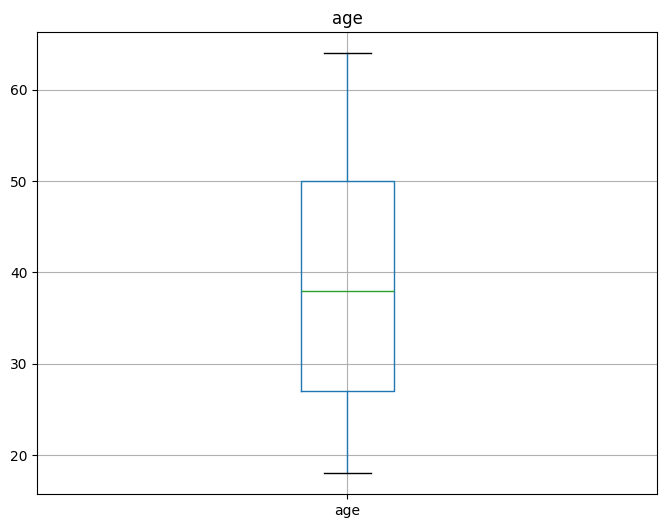

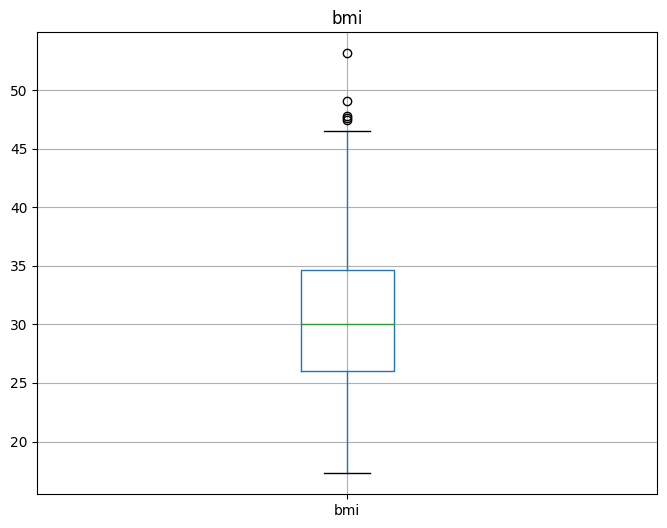

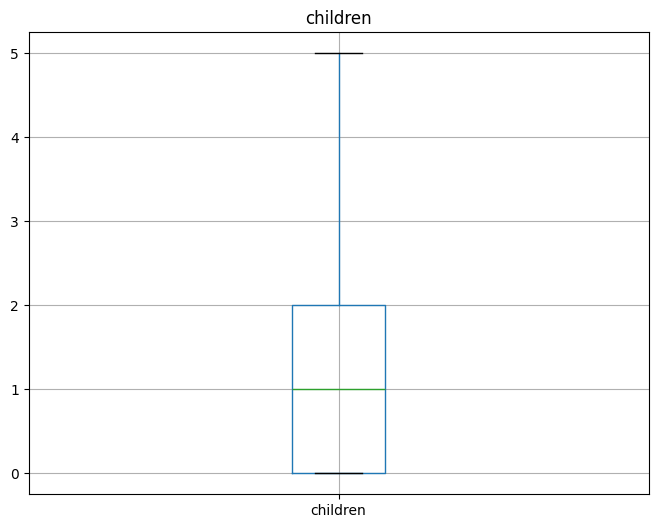

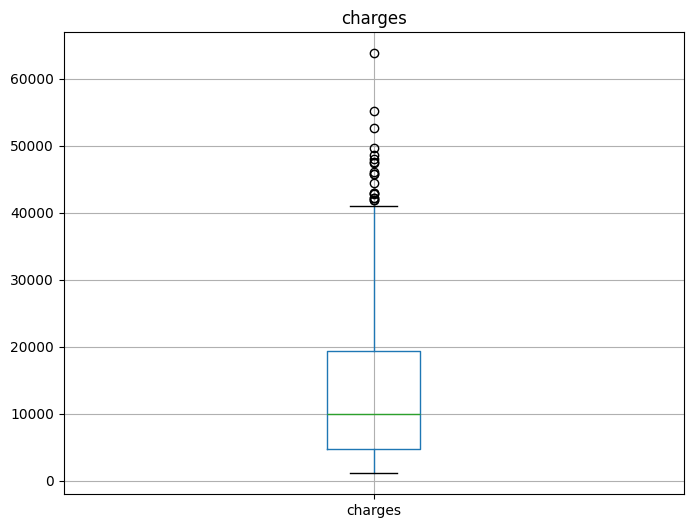

In [13]:
# выбросы
for col in ['age', 'bmi', 'children', 'charges']:
    plt.figure(figsize=(8, 6))
    df_train.boxplot(column=col)
    plt.title(col)
    plt.show()

колонки bmi и charges содержат выбросы

In [30]:
df_train['region'].unique()

array(['southeast', 'northwest', 'southwest', 'northeast'], dtype=object)

In [36]:
def isMale(x):
    return 1 if x == 'male' else 0

df_train['sex'] = df_train['sex'].apply(isMale)
df_test['sex'] = df_test['sex'].apply(isMale)

def isSmoker(x):
    return 1 if x == 'yes' else 0

df_train['smoker'] = df_train['smoker'].apply(isSmoker)
df_test['smoker'] = df_test['smoker'].apply(isSmoker)

region_dummies_train = pd.get_dummies(df_train['region'], prefix='region').astype(int)
region_dummies_test = pd.get_dummies(df_test['region'], prefix='region').astype(int)

df_train = pd.concat([df_train, region_dummies_train], axis=1)
df_test = pd.concat([df_test, region_dummies_test], axis=1)

df_train = df_train.drop('region', axis=1)
df_test = df_test.drop('region', axis=1)
    
df_train.head()

,age,sex,bmi,children,smoker,charges,region_northeast,region_northwest,region_southeast,region_southwest
0,26,1,27.060,0,1,17043.34140,0,0,1,0
1,58,1,36.955,2,1,47496.49445,0,1,0,0
2,20,0,24.420,0,1,26125.67477,0,0,1,0
3,51,0,38.060,0,1,44400.40640,0,0,1,0
4,62,0,25.000,0,0,13451.12200,0,0,0,1


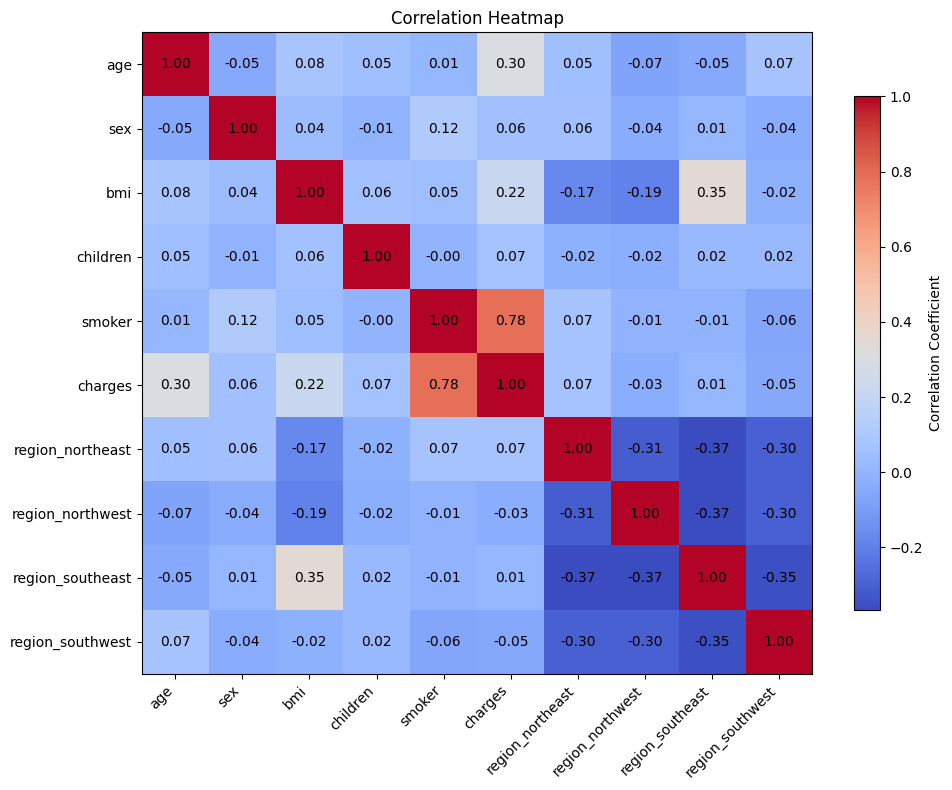

In [38]:
corr_matrix = df_train.corr()

fig, ax = plt.subplots(figsize=(10, 8))

im = ax.imshow(corr_matrix, cmap='coolwarm', aspect='auto')

cbar = plt.colorbar(im, ax=ax, shrink=0.8)
cbar.set_label('Correlation Coefficient')

ax.set_xticks(np.arange(len(corr_matrix.columns)))
ax.set_yticks(np.arange(len(corr_matrix.columns)))
ax.set_xticklabels(corr_matrix.columns, rotation=45, ha='right')
ax.set_yticklabels(corr_matrix.columns)

for i in range(len(corr_matrix.columns)):
    for j in range(len(corr_matrix.columns)):
        text = ax.text(j, i, f'{corr_matrix.iloc[i, j]:.2f}',
                       ha="center", va="center", color="black", fontsize=10)

ax.set_title('Correlation Heatmap')
plt.tight_layout()
plt.show()

## 2. Многомерная линейная регрессия
Построить модель линейной регрессии и подобрать параметры:
1. аналитически (реализовать самому)
2. численно, с помощью методов градиентного спуска (реализовать самому)

In [40]:
train = df_train.to_numpy()
test = df_test.to_numpy()
print(train[0:3])

[[2.60000000e+01 1.00000000e+00 2.70600000e+01 0.00000000e+00
  1.00000000e+00 1.70433414e+04 0.00000000e+00 0.00000000e+00
  1.00000000e+00 0.00000000e+00]
 [5.80000000e+01 1.00000000e+00 3.69550000e+01 2.00000000e+00
  1.00000000e+00 4.74964944e+04 0.00000000e+00 1.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.00000000e+01 0.00000000e+00 2.44200000e+01 0.00000000e+00
  1.00000000e+00 2.61256748e+04 0.00000000e+00 0.00000000e+00
  1.00000000e+00 0.00000000e+00]]


In [217]:
X = df_train.drop('charges', axis=1).to_numpy()
y = df_train['charges'].to_numpy()
X_test = df_test.drop('charges', axis=1).to_numpy()
y_test = df_test['charges'].to_numpy()
print(X[0])
print(y[0])

[26.    1.   27.06  0.    1.    0.    0.    1.    0.  ]
17043.3414


In [221]:
class LinearRegression:
    def fit(self, X, y):
        X = np.insert(X, 0, 1, axis=1)
        weights = np.linalg.multi_dot([np.linalg.pinv(X.T @ X), X.T, y]) #(X^T * X) ^ -1 * X^T * y 
        self.bias, self.weights = weights[0], weights[1:]

    def predict(self, X_test):
        return X_test @ self.weights + self.bias

In [222]:
model = LinearRegression()
model.fit(X, y)
pred_train = model.predict(X)
pred = model.predict(X_test)
def RMSE_error(y, pred):
    return np.sqrt(np.mean((y - pred) ** 2))

print(model.bias, model.weights)

-9772.604151869331 [  256.71070712  -655.40504609   350.86390876   483.10419606
 23401.99257013 -1685.40345897 -1885.99044547 -3075.29919116
 -3125.91105627]


In [223]:
print(RMSE_error(y, pred_train))
print(RMSE_error(y_test, pred))

6657.709217589472
5849.445166751281


In [170]:
class LinearRegressionGrad:

    def __init__(self, lr = 0.0001, n_iters=50001, epsilon=1e-6):
        self.lr = lr
        self.n_iters = n_iters
        self.bias = None
        self.weights = None
        self.epsilon = epsilon

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.bias, self.weights = 0, np.zeros(n_features)

        for i in range(self.n_iters):
            y_pred = X @ self.weights + self.bias

            error = y_pred - y
            loss = np.mean(error ** 2)

            dw = (2 / n_samples) * X.T @ error
            db = (2 / n_samples) * np.sum(error)

            self.weights -= self.lr * dw
            self.bias -= self.lr * db
            
            if i % 1000 == 0:
                print(f'Iter {i}, Loss: {loss}')
            
            if np.linalg.norm(dw) < self.epsilon and abs(db) < self.epsilon:
                print(f'Converged at iteration {i}, Loss: {loss:.6f}')
                break


    def predict(self, X_test):
        return X_test @ self.weights + self.bias


In [171]:
model_with_grad = LinearRegressionGrad()
model_with_grad.fit(X,y)
pred_train_with_grad = model_with_grad.predict(X)
pred_with_grad = model_with_grad.predict(X_test)

Iter 0, Loss: 361771951.78763753
Iter 1000, Loss: 137856696.03147492
Iter 2000, Loss: 131581769.19653952
Iter 3000, Loss: 125766696.723638
Iter 4000, Loss: 120371294.90437931
Iter 5000, Loss: 115361038.12192948
Iter 6000, Loss: 110705510.71816579
Iter 7000, Loss: 106377462.3327773
Iter 8000, Loss: 102352207.6995476
Iter 9000, Loss: 98607225.40905583
Iter 10000, Loss: 95121873.69046181
Iter 11000, Loss: 91877176.85443248
Iter 12000, Loss: 88855655.99183533
Iter 13000, Loss: 86041188.72653429
Iter 14000, Loss: 83418889.12754959
Iter 15000, Loss: 80975002.45041727
Iter 16000, Loss: 78696811.40494461
Iter 17000, Loss: 76572551.81093925
Iter 18000, Loss: 74591336.18227942
Iter 19000, Loss: 72743084.18421088
Iter 20000, Loss: 71018459.15744321
Iter 21000, Loss: 69408810.0619657
Iter 22000, Loss: 67906118.30089428
Iter 23000, Loss: 66502948.961235315
Iter 24000, Loss: 65192406.0661629
Iter 25000, Loss: 63968091.47914617
Iter 26000, Loss: 62824067.13799962
Iter 27000, Loss: 61754820.329024
Ite

In [172]:
print(model_with_grad.bias, model_with_grad.weights)

-2817.5929597194113 [  213.96803201  -399.49562186   160.16776791   363.32437942
 19199.18454519   119.88246649  -638.32945111  -772.95442115
 -1526.19155395]


In [173]:
print(RMSE_error(y, pred_train_with_grad))
print(RMSE_error(y_test, pred_with_grad))

7035.465860035708
6294.9364184511405


In [176]:
# Сравнение
print('Аналитическое решение RMSE:',RMSE_error(y_test, pred))
print('Градиентный спуск RMSE:',RMSE_error(y_test, pred_with_grad))

Аналитическое решение RMSE: 5849.445166751281
Градиентный спуск RMSE: 6294.9364184511405


## 3. Добавление регуляризации
Модифицировать линейную модель путем добавления регуляризационного слагаемого. Найти оптимальные веса:
1. аналитически
2. численно

In [224]:
class LinearRegressionGreb:
    def __init__(self, alpha=0.3):
        self.alpha = alpha
        self.bias = None
        self.weights = None

    def fit(self, X, y):
        X = np.insert(X, 0, 1, axis=1)
        I = np.eye(X.shape[1])
        I[0, 0] = 0
        weights = np.linalg.multi_dot([np.linalg.inv(X.T @ X + self.alpha * I), X.T, y]) #(X^T * X) ^ -1 * X^T * y 
        self.bias, self.weights = weights[0], weights[1:]

    def predict(self, X_test):
        return X_test @ self.weights + self.bias

In [227]:
best_model = LinearRegressionGreb()
best_pred_greb = np.zeros_like(y)
best_alpha = 0
for alpha in np.logspace(-3, 1):
    model = LinearRegressionGreb(alpha=alpha)
    model.fit(X, y)
    pred_train_greb = model.predict(X)
    pred_greb = model.predict(X_test)
    if RMSE_error(y, pred_train_greb) < RMSE_error(y, best_pred_greb):
        best_model = model
        best_pred_greb = pred_train_greb

pred_train_greb = best_model.predict(X)
pred_greb = best_model.predict(X_test)
print(best_model.alpha)
print(best_model.bias, best_model.weights)

0.001
-12215.729236245155 [  256.71085463  -655.35909174   350.86514239   483.10291337
 23401.59367656   757.76046073   557.1557771   -632.14827633
  -682.76796198]


In [228]:
print(RMSE_error(y, pred_train_greb))
print(RMSE_error(y_test, pred_greb))

6657.709219667508
5849.45214469701


In [232]:
class LinearRegressionGradGreb:
    def __init__(self, lr = 0.0001, n_iters=50001, epsilon=1e-6, alpha=0.01):
        self.lr = lr
        self.n_iters = n_iters
        self.bias = None
        self.weights = None
        self.epsilon = epsilon
        self.alpha = alpha

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.bias, self.weights = 0, np.zeros(n_features)

        for i in range(self.n_iters):
            y_pred = X @ self.weights + self.bias

            error = y_pred - y
            loss = np.mean(error ** 2)

            dw = (2 / n_samples) * X.T @ error + 2 * self.alpha * self.weights
            db = (2 / n_samples) * np.sum(error)

            self.weights -= self.lr * dw
            self.bias -= self.lr * db
            
            # if i % 1000 == 0:
            #     print(f'Iter {i}, Loss: {loss}')
            
            # if np.linalg.norm(dw) < self.epsilon and abs(db) < self.epsilon:
            #     print(f'Converged at iteration {i}, Loss: {loss:.6f}')
            #     break


    def predict(self, X_test):
        return X_test @ self.weights + self.bias


In [234]:
best_model = LinearRegressionGradGreb()
best_pred_greb = np.zeros_like(y)
best_alpha = 0
for alpha in np.logspace(-3, 1):
    model = LinearRegressionGradGreb(alpha=alpha)
    model.fit(X, y)
    pred_train_greb = model.predict(X)
    pred_greb = model.predict(X_test)
    if RMSE_error(y, pred_train_greb) < RMSE_error(y, best_pred_greb):
        best_model = model
        best_pred_greb = pred_train_greb

pred_train_greb_grad = best_model.predict(X)
pred_greb_grad = best_model.predict(X_test)
print(best_model.alpha)
print(best_model.bias, best_model.weights)

0.001
-2816.905740687383 [  213.99829882  -394.82988597   160.43405878   363.02952645
 19130.33354559   122.94334287  -634.53127037  -769.82307079
 -1521.12415246]


In [235]:
print(RMSE_error(y, pred_train_greb_grad))
print(RMSE_error(y_test, pred_greb_grad))

7042.657969793639
6302.861354656435


## 4. Оценка обобщающей способности
Сравнить между собой модели на тестовых данных по среднему квадрату ошибки:
1. константную - прогноз средним значением
2. из пункта 2
3. из пункта 3

In [238]:
print('Модели')
print('Константа:', RMSE_error(y_test, np.full_like(y_test, np.mean(y))))
print('Аналитическая:', RMSE_error(y_test, pred))
print('Численная:', RMSE_error(y_test, pred_with_grad))
print('Аналитическая с регуляризацией:', RMSE_error(y_test, pred))
print('Численная с регуляризацией:', RMSE_error(y_test, pred_with_grad))

Модели
Константа: 11909.244071688154
Аналитическая: 5849.445166751281
Численная: 6294.9364184511405
Аналитическая с регуляризацией: 5849.445166751281
Численная с регуляризацией: 6294.9364184511405
